In [3]:
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from numpy.random import seed
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from itertools import combinations

/home/sandeepubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Class: Sequential Backward Selection (SBS) Classifier

In [28]:
class SBS():
    def __init__(self,estimator, k_features,scoring=accuracy_score,test_size=0.23, random_state=1):
        self.scoring=scoring
        self.estimator=estimator
        self.k_features=k_features
        self.test_size=test_size
        self.random_state=random_state
        
    def fit(self,X,y):
        X_train,X_test, y_train,y_test = \
                            train_test_split(X,y,test_size=self.test_size,
                                             random_state=self.random_state)
            
        dim=X_train.shape[1]
        self.indices_ = tuple(range(dim))
        #print(self.indices_)
        self.subsets_ = [self.indices_]
        # on all indices first time
        score=self._calc_score(X_train,y_train,X_test,y_test,self.indices_)
        self.scores_=[score]
        
        while dim > self.k_features:
            scores=[]
            subsets=[]
            
            for p in combinations(self.indices_, r=dim-1):
                
                #print(p)
                score=self._calc_score(X_train,y_train,
                                       X_test, y_test,p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)    
            dim -= 1            
            self.scores_.append(scores[best])
            
        self.k_score_ = self.scores_[-1]
        #print(self.k_score_)
        #input()
        return self
    
    def transform(self,X):
        return X[:,self.indices_]
    
    def _calc_score(self, X_train, y_train, 
                    X_test, y_test, indices):
        self.estimator.fit(X_train[:,indices],y_train)
        y_pred = self.estimator.predict(X_test[:,indices])
        score = self.scoring(y_test,y_pred)
        return score
    

        
    

In [8]:
# Read from csv 

csv_data = '''A,B,C,D
              1.0,2.0,3.0,4.0
              5.0,6.0,,8.0
              10.0,11.0,12.0,'''

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [9]:
# Check if there are null values
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [12]:
# Drop the row/ col containing NaN
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [16]:
# If NaN, replace the feat with the mean of that row/column
# Strategy can be: mean, median, most_frequent
imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df)
imputed_data = imr.transform(df.values)
print(imputed_data)

array([[  1. ,   2. ,   3. ,   4. ],
       [  5. ,   6. ,   7.5,   8. ],
       [ 10. ,  11. ,  12. ,   6. ]])

In [54]:
# Handling catagorical data

df = pd.DataFrame([  
                ['green','M',10.1,'class1'], 
                ['red','L',13.5,'class2'],
                ['blue','XL',15.3,'class1']])

df.columns=['color','size','price','classlabel']
df



,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


In [55]:
# Convert string to values
size_mapping = { 'XL':3,
                 'L':2,
                 'M':1}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [56]:
# Encode the class labels
class_mapping = {label:idx for idx,label in 
                              enumerate(np.unique(df['classlabel']))}

df['classlabel'] = df['classlabel'].map(class_mapping)
df
class_mapping
# inverse 



{'class1': 0, 'class2': 1}

In [57]:
inv_class_mapping = {v:k for k,v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df


,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [59]:
# Using scikit-learn's LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
#print(y)
class_le.inverse_transform(y)


array(['class1', 'class2', 'class1'], dtype=object)

In [70]:
# Using one-hot encoding of input data
X = df[['color','size','price']].values
color_le = LabelEncoder()
X[:,0] = color_le.fit_transform(X[:,0])
print('Using Label Encoder:\n',X)

ohe = OneHotEncoder(categorical_features=[0])
print('\nUsing One-Hot Encoding:')
X_one_hot = ohe.fit_transform(X).toarray()
print(X_one_hot)

Using Label Encoder:
 [[1 1 10.1]
 [2 2 13.5]
 [0 3 15.3]]

Using One-Hot Encoding:
[[  0.    1.    0.    1.   10.1]
 [  0.    0.    1.    2.   13.5]
 [  1.    0.    0.    3.   15.3]]


### Wine Dataset

In [5]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
'Alcalinity of ash', 'Magnesium', 'Total phenols', 
'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
# Read the input data 
X,y = df_wine.iloc[:,1:].values,df_wine.iloc[:,0].values
print('The overall dataset is of dimension %d x %d'%(X.shape[0],X.shape[1]))
print('The overall labels is of dimension %d'%(len(y)))

The overall dataset is of dimension 178 x 13
The overall labels is of dimension 178


In [7]:
# Split into train and test
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)
print('The training features are of dimension %d x %d'%(X_train.shape[0],X_train.shape[1]))
print('The test features are of dimension %d x %d'%(X_test.shape[0],X_test.shape[1]))
print('The training labels are of dimension %d'%(len(y_train)))
print('The test labels are of dimension %d'%(len(y_test)))

The training features are of dimension 124 x 13
The test features are of dimension 54 x 13
The training labels are of dimension 124
The test labels are of dimension 54


In [8]:
# Normalize the data
#mms = MinMaxScaler()
#X_train_norm = mms.fit_transform(X_train)
#X_test_norm = mms.transform(X_test)

# OR 
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)


In [9]:
# Applying logistic regression on Wine data
lr = LogisticRegression(penalty='l1',C=0.1)
lr.fit(X_train_std, y_train)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
print('Training accuracy: %f'%(lr.score(X_train_std,y_train)))
print('Test accuracy: %f'%(lr.score(X_test_std,y_test)))

Training accuracy: 0.983871
Test accuracy: 0.981481


### Sequential feature selection

In [29]:
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn,k_features=1)


#sbs.fit(X_train_std,y_train)

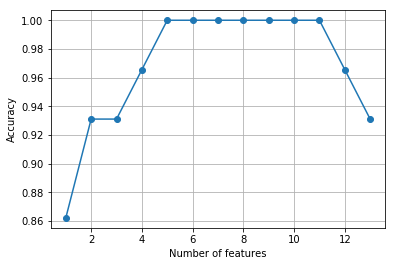

In [30]:
sbs.fit(X_train_std,y_train)

k_feat = [len(k) for k in sbs.subsets_]
#print(k_feat)
#print(sbs.scores_)
plt.plot(k_feat,sbs.scores_,marker='o')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [128]:
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


In [129]:
# Original test set
knn.fit(X_train_std, y_train)
print('Training accuracy: %f'%(knn.score(X_train_std,y_train)))
print('Test accuracy: %f'%(knn.score(X_test_std,y_test)))


Training accuracy: 0.983871
Test accuracy: 0.944444


In [131]:
# Best features
knn.fit(X_train_std[:,k5], y_train)
print('Training accuracy Best features: %f'%(knn.score(X_train_std[:,k5],y_train)))
print('Test accuracy Best features: %f'%(knn.score(X_test_std[:,k5],y_test)))

Training accuracy Best features: 0.959677
Test accuracy Best features: 0.962963
